In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import torch
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2
import json

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model_ident = "bidiretional_lstm_hrnet_nturgb"
unique_iden = "epoch10_emb1024_xy"

main_dir = "D:\\FYP\\HAR-ZSL-XAI"
data_files = os.path.join(main_dir,"pyskl","HRNetSkeletons","nipun_video_dataset","PAMAP2_K10_V1","combined.pkl")
epoch_vids = os.path.join(main_dir,"epoch_vids")
models_saves = os.path.join(main_dir,"model_saves")
embeddings_save = os.path.join(main_dir,"embedding_save")
prototypes_save = os.path.join(main_dir,"prototypes")
test_vids = os.path.join(main_dir,"test_vids")
batch_size = 32

os.makedirs(embeddings_save,exist_ok=True)

In [4]:
from utils.test_utils import *
from dataset.SkeletonData.array_segment import normalize_array

In [5]:
model_params, model_config, config = get_config(f"{models_saves}/{model_ident}/{unique_iden}.pt")

In [6]:
def classname_id(class_name_list):
    id2classname = {k:v for k, v in zip(list(range(len(class_name_list))),class_name_list)}
    classname2id = {v:k for k, v in id2classname.items()}
    return id2classname, classname2id

In [7]:
 class_names = [str(x) for x in os.listdir("../data/nipun_video_dataset/PAMAP2_K10_V1")]

In [8]:
id2clsname, clsname2id = classname_id(class_names)

In [9]:
with open(data_files,"rb") as f0:
    filelist = pickle.load(f0)

filter_arr = []
for __f in filelist:
    if len(__f["keypoint"].shape) == 4 and __f["keypoint"].shape[0]>0:
        filter_arr.append(__f)

num_list = len(filter_arr)

In [10]:
num_list

173

In [11]:
set_fil = set()
for fil in filter_arr:
    set_fil.add(fil["frame_dir"])

set_fil,len(set_fil)

({'as10',
  'as12',
  'as13',
  'as14',
  'as15',
  'as16',
  'as18',
  'as7',
  'as8',
  'as9',
  'c10',
  'c14',
  'c16',
  'c17',
  'c18',
  'c2',
  'c20',
  'c4',
  'c6',
  'c9',
  'cd11',
  'cd16',
  'cd18',
  'cd19',
  'cd5',
  'cd6',
  'cd9',
  'cw10',
  'cw11',
  'cw13',
  'cw17',
  'cw18',
  'cw19',
  'cw2',
  'cw23',
  'cw24',
  'cw6',
  'ds1',
  'ds10',
  'ds12',
  'ds13',
  'ds18',
  'ds20',
  'ds22',
  'ds5',
  'ds7',
  'ds9',
  'fl10',
  'fl12',
  'fl13',
  'fl16',
  'fl18',
  'fl2',
  'fl4',
  'fl5',
  'fl6',
  'fl8',
  'hc11',
  'hc13',
  'hc17',
  'hc18',
  'hc2',
  'hc20',
  'hc22',
  'hc5',
  'hc7',
  'hc9',
  'i12',
  'i13',
  'i16',
  'i19',
  'i21',
  'i26',
  'i28',
  'i32',
  'i4',
  'i7',
  'l11',
  'l12',
  'l13',
  'l16',
  'l17',
  'l18',
  'l20',
  'l3',
  'l4',
  'nw1',
  'nw10',
  'nw14',
  'nw16',
  'nw18',
  'nw20',
  'nw3',
  'nw5',
  'nw6',
  'nw8',
  'ps1',
  'ps10',
  'ps12',
  'ps13',
  'ps18',
  'ps20',
  'ps3',
  'ps5',
  'ps7',
  'ps9',
  'r1',


In [12]:
class SkeletonDataset(Dataset):
    def __init__(self, file_list,class2id, transform=None,
                 target_transform=None,active_locations=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],file_name=False, is_2d=False):
        self.file_list = file_list
        self.transform = transform
        self.class2id = class2id
        self.target_transform = target_transform
        self.active_locations = active_locations
        self.file_name = file_name
        self.is_2d = is_2d

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        a_file = self.file_list[idx]
        action_type = a_file["label"]
        coords, vidsize = a_file["keypoint"][0],a_file["original_shape"]
        coords = coords[10:60,:,:]
        coords = coords[:,self.active_locations,:]

        normalize_array(coords,vidsize)
        if self.is_2d:
            coords = coords[...,0:2]

        shape = coords.shape

        coords = torch.from_numpy(coords).float()

        coords = torch.reshape(coords, (shape[0], shape[1]*shape[2]))
        label = torch.clone(coords)

        if self.transform:
            coords = self.transform(coords)
        if self.target_transform:
            label = self.target_transform(coords)

        if self.file_name:
            return coords, label, self.class2id[action_type],a_file["original_shape"],self.file_list[idx]["frame_dir"]
        return coords, label, self.class2id[action_type],a_file["original_shape"]

In [13]:
skel_data = SkeletonDataset(filter_arr,clsname2id,is_2d=True,file_name=True)

In [14]:
skel_dl = DataLoader(skel_data, batch_size=32, shuffle=False)

In [15]:
for x in skel_dl:
    print(x[0].shape)
    break

torch.Size([32, 50, 24])


In [16]:
class BiLSTMEncoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size,linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev=dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        # define LSTM layer
        self.layers = []

        # add linear layers 
        for __id,layer_out in enumerate(self.linear_filters):
            if __id == 0:
                self.layers.append(nn.Linear(self.input_size, layer_out))
            else:
                self.layers.append(nn.Linear(self.linear_filters[__id-1], layer_out))

        # add lstm layer
        self.lstm = nn.LSTM(input_size = layer_out, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True)
        
        self.net = nn.Sequential(*self.layers)

        #add embedding out
        if bidirectional:
            self.out_linear = nn.Linear(self.hidden_size*4, self.embedding_size)
        else:
            self.out_linear = nn.Linear(self.hidden_size*2, self.embedding_size)

        
    def forward(self, x_input):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        x = self.net(x_input)
        lstm_out, self.hidden = self.lstm(x)
        hidden_transformed = torch.cat(self.hidden,0)
        hidden_transformed = torch.transpose(hidden_transformed,0,1)
        hidden_transformed = torch.flatten(hidden_transformed,start_dim=1)
        
        hidden_transformed = self.out_linear(hidden_transformed)
        
        return lstm_out, hidden_transformed

    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)

                        
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

        
        

    def forward(self,encoder_hidden):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((-1,4,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
            bs = h.size()[1]
        else:
            hidden = encoder_hidden.view((-1,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
            bs = h.size()[1]
        
        dummy_input = torch.rand((bs,self.seq_len,self.hidden_size), requires_grad=True).to(self.dev)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        
        return x

class BiLSTMEncDecModel(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters=[128,256,512],embedding_size:int=256, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMEncDecModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        self.encoder = BiLSTMEncoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True, dev=self.dev)
        self.decoder = BiLSTMDecoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True, dev=self.dev)
        
    def forward(self,x):
        lstm_out,embedding = self.encoder(x)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding  


In [17]:
config

{'n_epochs': 50,
 'model_name': 'BidirectionalLSTM',
 'model': {'seq_len': 50,
  'input_size': 24,
  'hidden_size': 1024,
  'linear_filters': [128, 256, 512, 1024],
  'embedding_size': 1024,
  'num_layers': 1,
  'bidirectional': True,
  'batch_size': 256,
  'dev': device(type='cuda')}}

In [18]:
bilstm_model = BiLSTMEncDecModel(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    dev=config["model"]["dev"])

In [19]:
bilstm_model.to(device)

BiLSTMEncDecModel(
  (encoder): BiLSTMEncoder(
    (lstm): LSTM(1024, 1024, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=24, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): Linear(in_features=512, out_features=1024, bias=True)
    )
    (out_linear): Linear(in_features=4096, out_features=1024, bias=True)
  )
  (decoder): BiLSTMDecoder(
    (input_linear): Linear(in_features=1024, out_features=4096, bias=True)
    (lstm): LSTM(1024, 1024, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=2048, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=512, bias=True)
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): Linear(in_features=128, out_features=24, bias=True)
    )
  )

In [20]:
bilstm_model.load_state_dict(model_params)

<All keys matched successfully>

In [21]:
lstm_out, embedding = bilstm_model.encoder(torch.randn((32,50,24)).to(device))

In [22]:

embedding.shape

torch.Size([32, 1024])

In [23]:
decoder_out = bilstm_model.decoder(embedding)

In [24]:
model_out,embedding = bilstm_model(torch.randn((1,50,24)).to(device))

In [25]:
model_out.shape

torch.Size([1, 50, 24])

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mapping_l = [
        [15, 13], [13, 11], [11, 5],
        [12, 14], [14, 16], [12, 6],
        [3, 1],[1, 2],[1, 0],[0, 2],[2,4],
        [9, 7], [7,5], [5, 6],
        [6, 8], [8, 10],
        ]
#mapping_l = []

from dataset.SkeletonData.visualize import *
from utils.train_utils import *

In [27]:
def model_predict(model,input_ten:torch.Tensor,dev):
    input_ten = input_ten.to(dev)
    _, embed_ten = model.encoder(input_ten)
    output_ten = model.decoder(embed_ten)

    return embed_ten, output_ten

def model_saves(loc,embed_ten,output_ten,detail_ten):
    np.savez(loc,embedding=embed_ten,output=output_ten,file_list=detail_ten)


In [28]:
file_map = []
embed_map = []
output_map = []
for data_point in skel_dl:
    arrays, labels, class_nms ,video_shape,file_details = data_point
    embeddings, outputs = model_predict(bilstm_model,arrays,device)
    embeddings = embeddings.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    for e,o,d,l,cln in zip(embeddings,outputs,file_details,labels,class_nms):
        file_map.append([d])
        embed_map.append(e)
        output_map.append(o)

file_map = np.asarray(file_map)
embed_map = np.asarray(embed_map)
output_map = np.asarray(output_map)

os.makedirs(f"{embeddings_save}/{model_ident}/{unique_iden}",exist_ok=True)
model_saves(f"{embeddings_save}/{model_ident}/{unique_iden}/without_pretrain_on_local.npz",embed_map,output_map,file_map)

## Visualizations

In [29]:
import hypertools as hyp
import pandas as pd
import re

In [30]:
output_data = np.load(f"{embeddings_save}/{model_ident}/{unique_iden}/without_pretrain_on_local.npz")

embed_arr,out_arr,file_arr = output_data["embedding"],output_data["output"],output_data["file_list"]

In [31]:
embed_arr.shape,out_arr.shape

((173, 1024), (173, 50, 24))

In [32]:
file_arr,np.unique(file_arr,return_counts=True)

(array([['as10'],
        ['as12'],
        ['as13'],
        ['as14'],
        ['as15'],
        ['as16'],
        ['as18'],
        ['as7'],
        ['as8'],
        ['as9'],
        ['cd11'],
        ['cd16'],
        ['cd18'],
        ['cd19'],
        ['cd5'],
        ['cd6'],
        ['cd9'],
        ['cw10'],
        ['cw11'],
        ['cw13'],
        ['cw17'],
        ['cw18'],
        ['cw19'],
        ['cw2'],
        ['cw23'],
        ['cw24'],
        ['cw6'],
        ['c10'],
        ['c14'],
        ['c16'],
        ['c17'],
        ['c18'],
        ['c2'],
        ['c20'],
        ['c4'],
        ['c6'],
        ['c9'],
        ['ds1'],
        ['ds10'],
        ['ds12'],
        ['ds13'],
        ['ds18'],
        ['ds20'],
        ['ds22'],
        ['ds5'],
        ['ds7'],
        ['ds9'],
        ['fl10'],
        ['fl12'],
        ['fl13'],
        ['fl16'],
        ['fl18'],
        ['fl2'],
        ['fl4'],
        ['fl5'],
        ['fl6'],
        ['fl8'],
     

In [33]:
import random

def draw_heatmaps(arr_list,nrows=2,ncols=2):
    ran_list = random.sample(arr_list,ncols*nrows)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, sharex=True)
    for i in range(nrows):
        for j in range(ncols):
            #print(i*ncols+j,len(ran_list))
            ax[i,j].imshow(ran_list[i*ncols+j].detach().cpu().numpy()[np.newaxis,:], cmap="plasma", aspect="auto")

    plt.tight_layout()
    plt.show()

In [34]:
embed_arr.shape

(173, 1024)

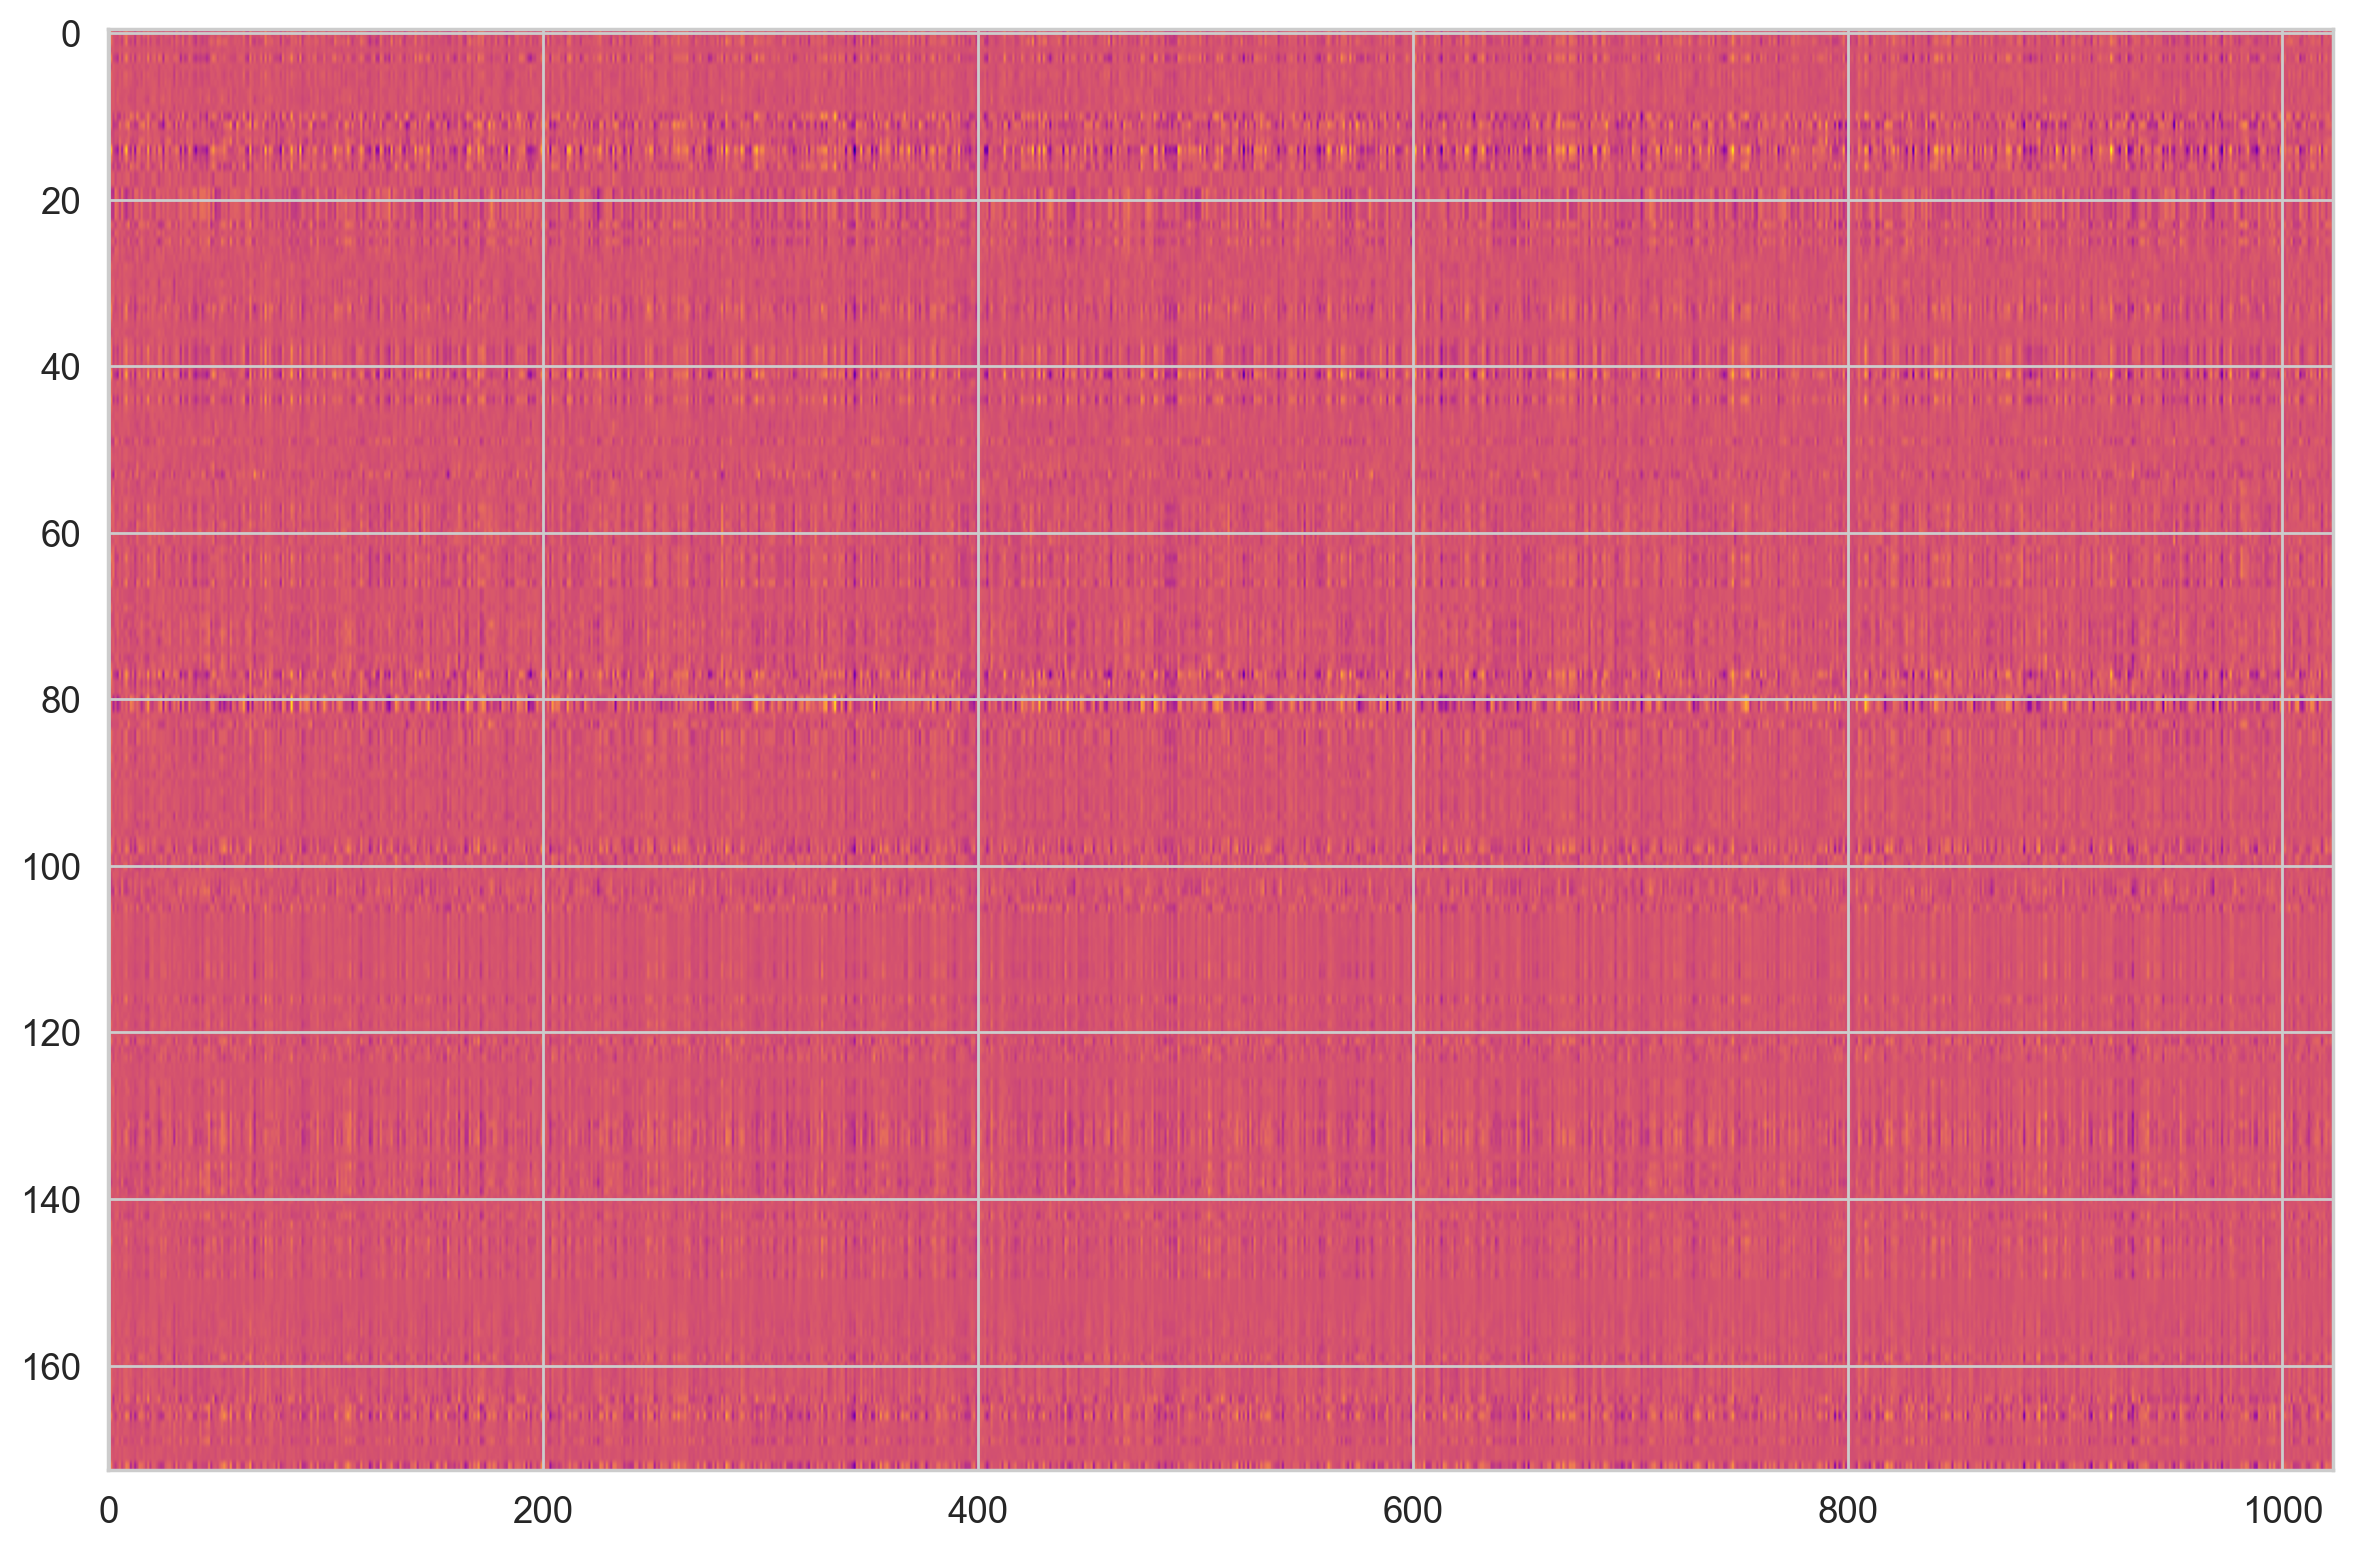

In [35]:
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.imshow(embed_arr, cmap="plasma", aspect="auto")

plt.tight_layout()
plt.show()

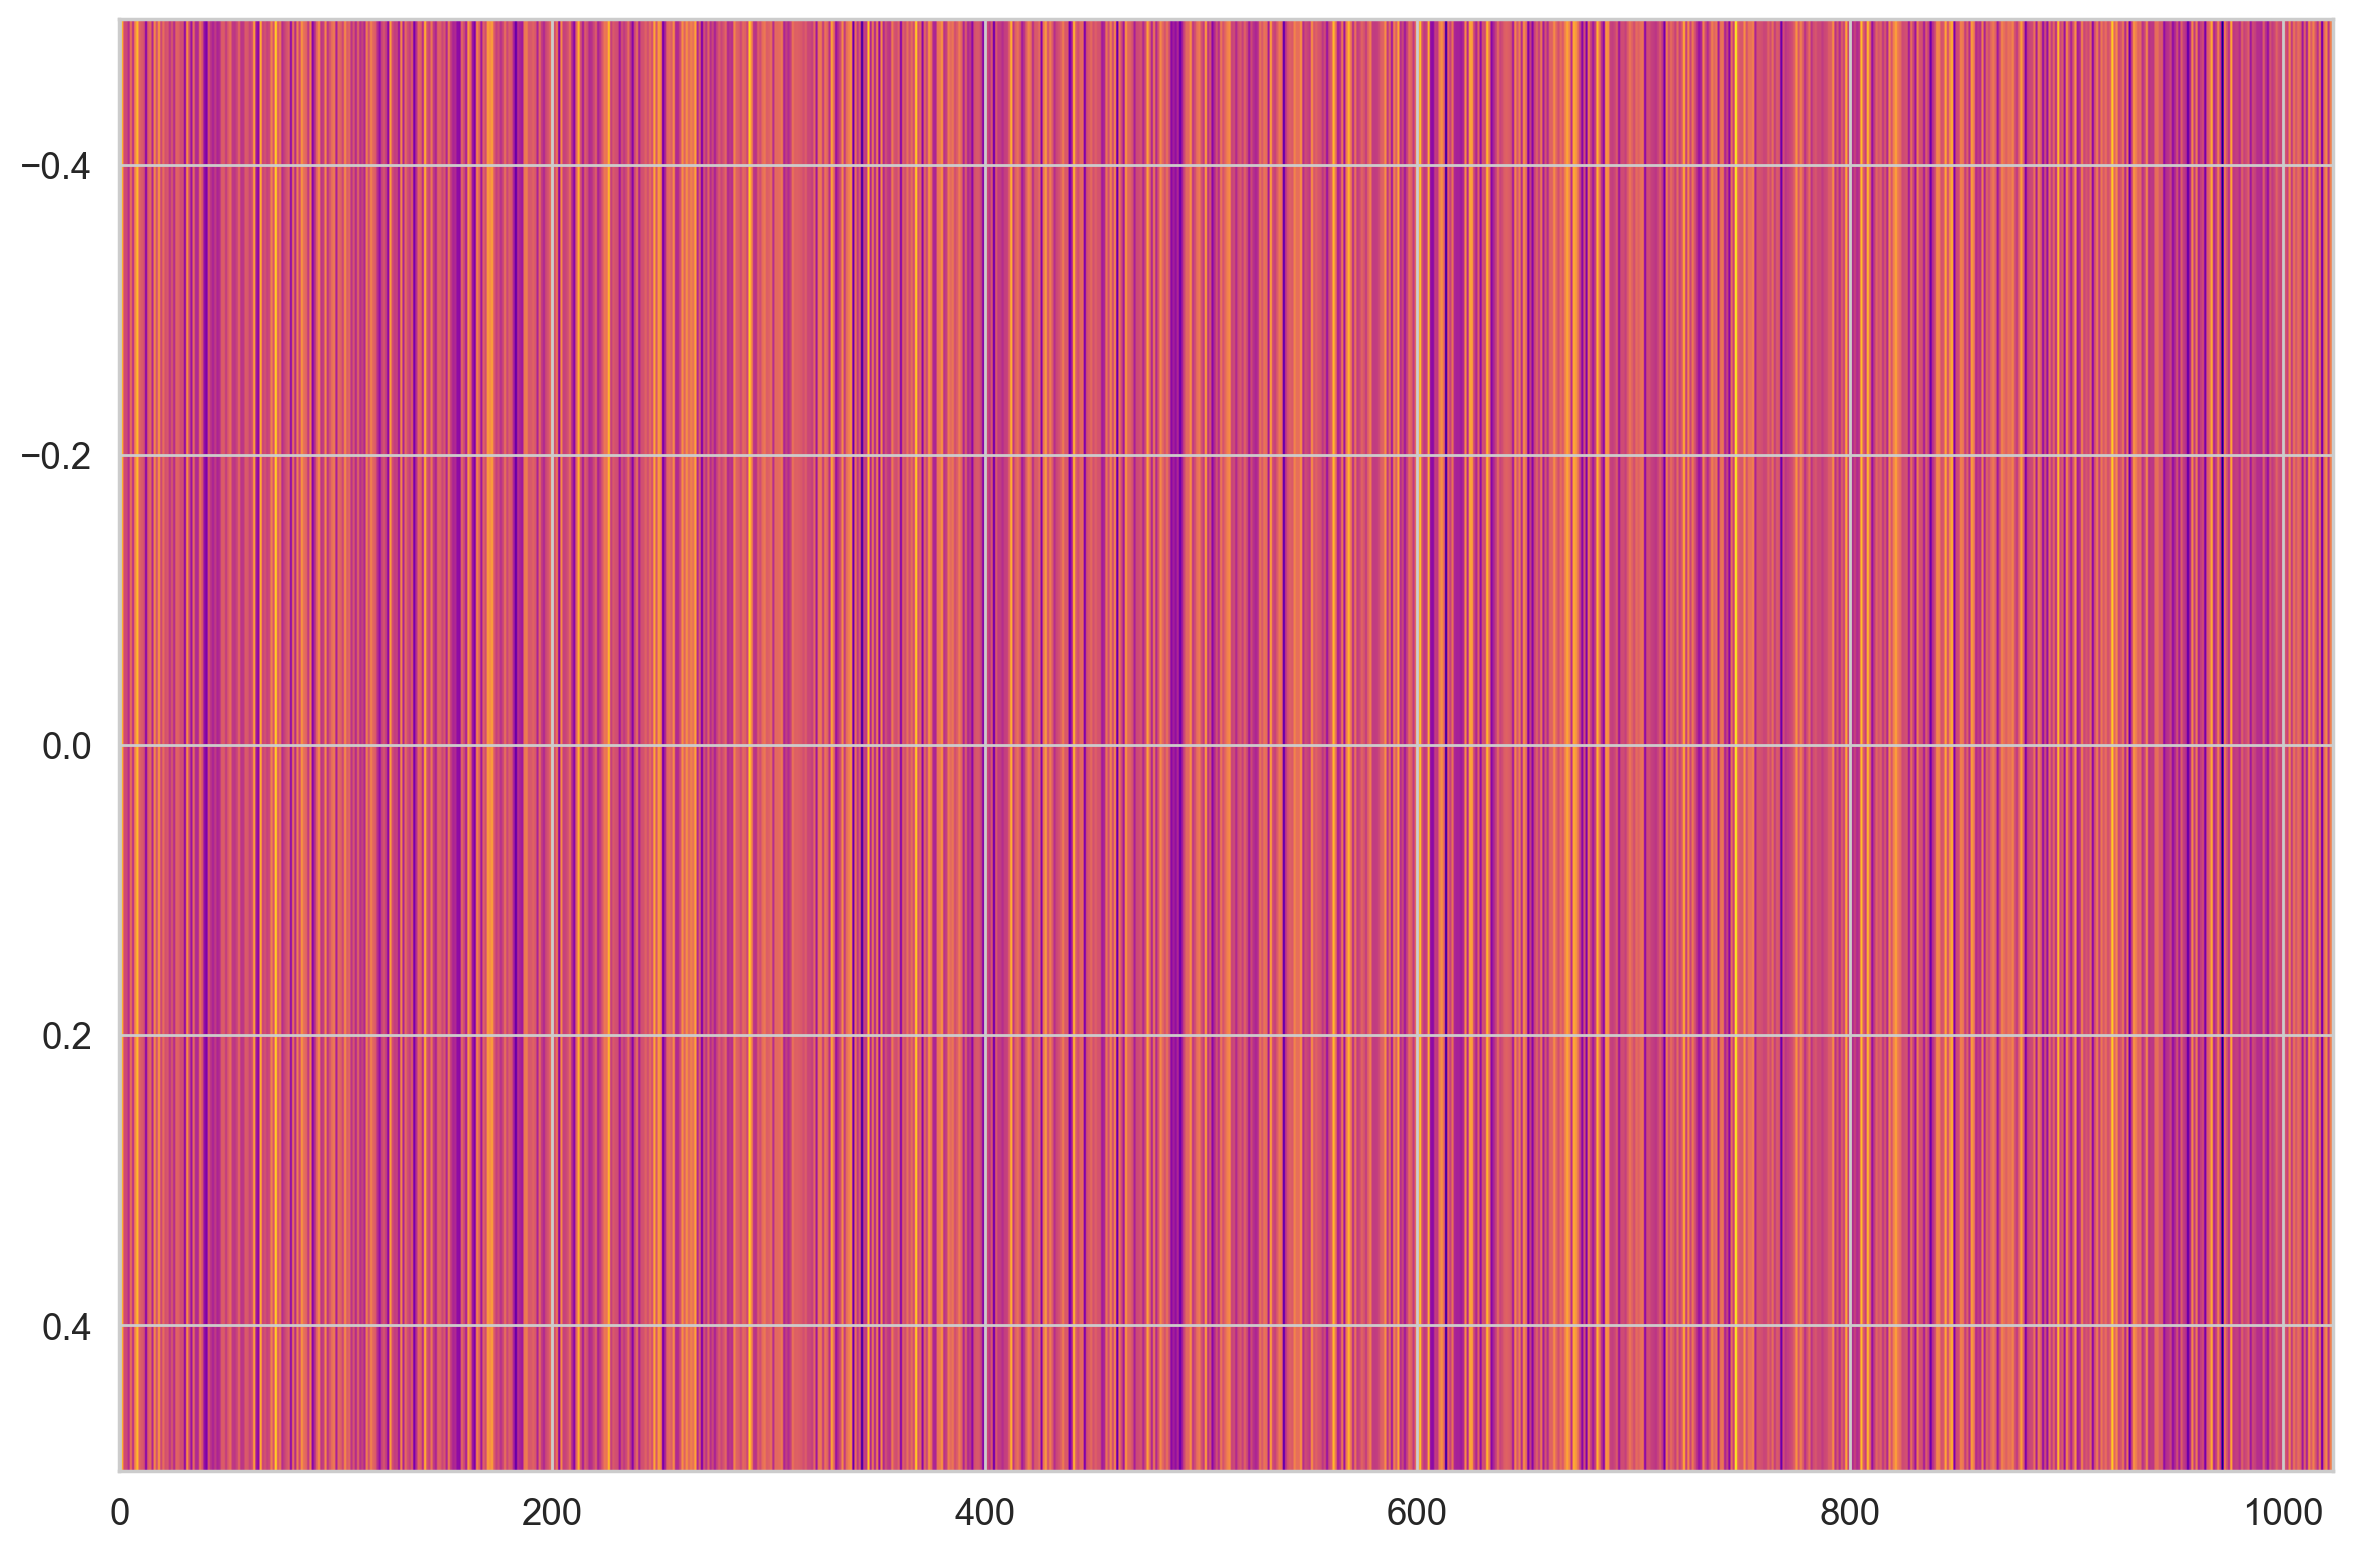

In [36]:
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.imshow(embed_arr[0][np.newaxis,:], cmap="plasma", aspect="auto")

plt.tight_layout()
plt.show()

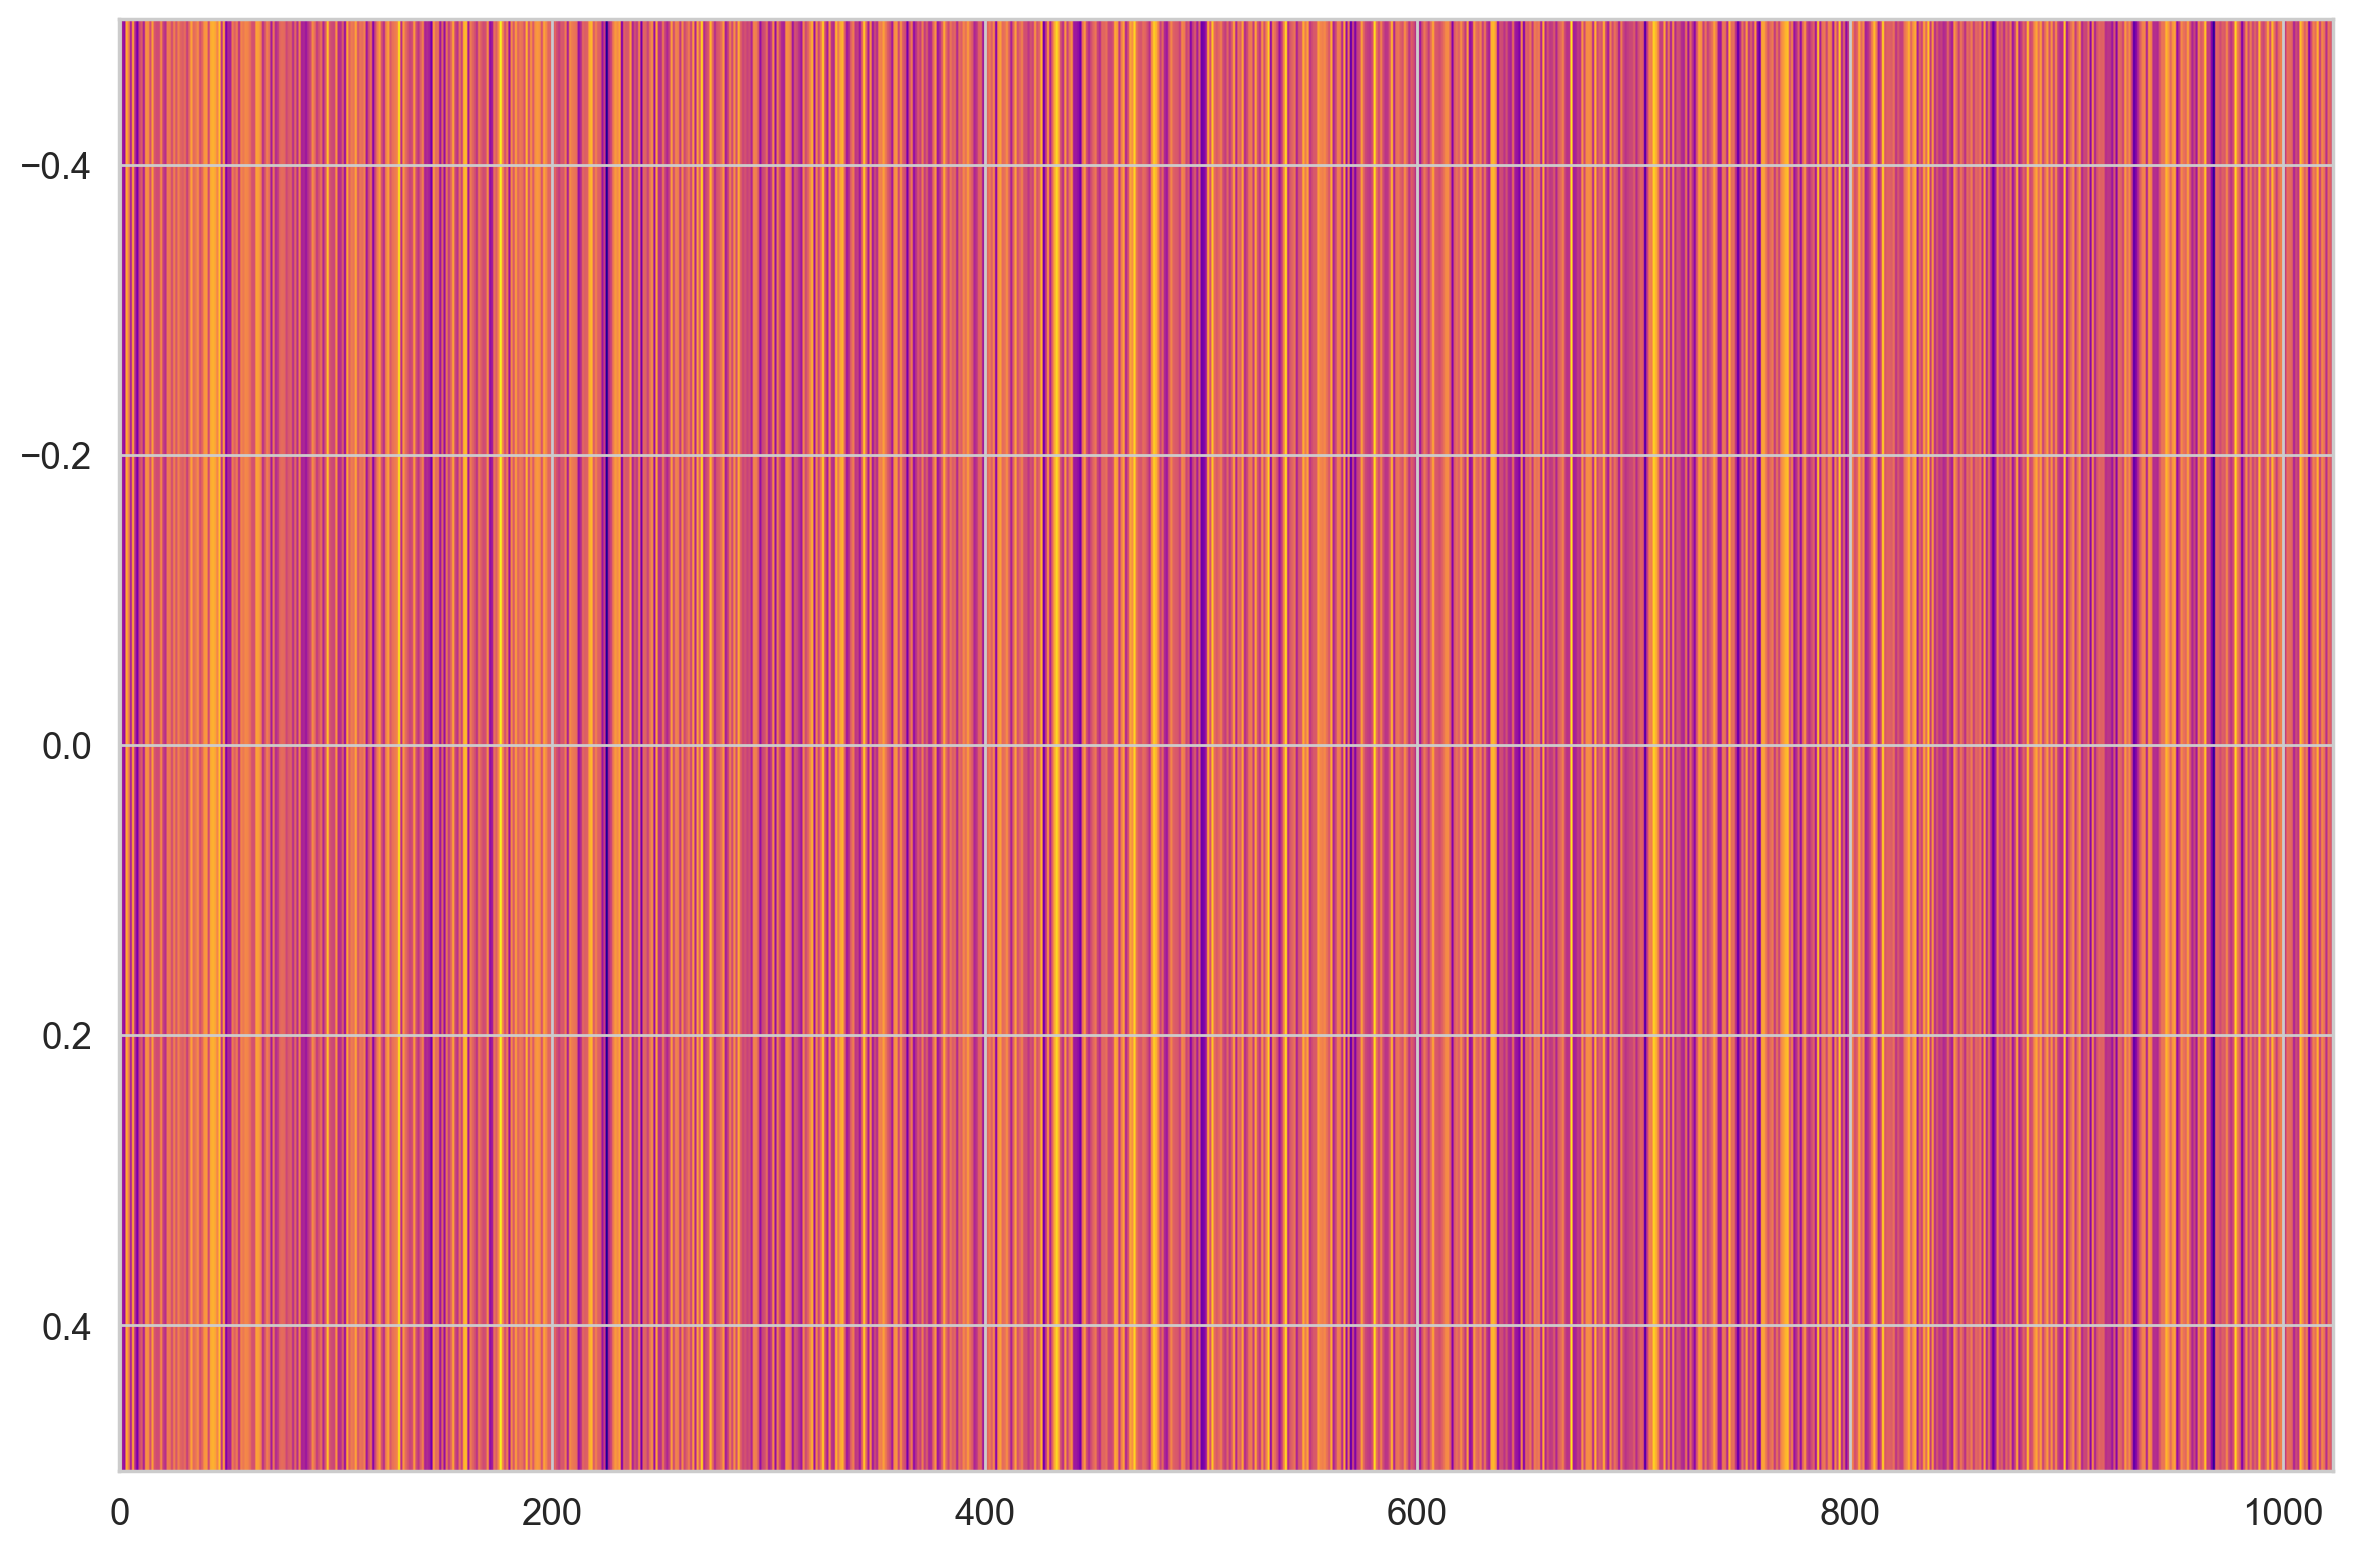

In [37]:
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.imshow(embed_arr[20][np.newaxis,:], cmap="plasma", aspect="auto")

plt.tight_layout()
plt.show()

In [38]:
class_names = [re.findall(r'[a-z]+',x[0])[0] for x in file_arr.tolist()]
class_names

['as',
 'as',
 'as',
 'as',
 'as',
 'as',
 'as',
 'as',
 'as',
 'as',
 'cd',
 'cd',
 'cd',
 'cd',
 'cd',
 'cd',
 'cd',
 'cw',
 'cw',
 'cw',
 'cw',
 'cw',
 'cw',
 'cw',
 'cw',
 'cw',
 'cw',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'ds',
 'ds',
 'ds',
 'ds',
 'ds',
 'ds',
 'ds',
 'ds',
 'ds',
 'ds',
 'fl',
 'fl',
 'fl',
 'fl',
 'fl',
 'fl',
 'fl',
 'fl',
 'fl',
 'fl',
 'hc',
 'hc',
 'hc',
 'hc',
 'hc',
 'hc',
 'hc',
 'hc',
 'hc',
 'hc',
 'i',
 'i',
 'i',
 'i',
 'i',
 'i',
 'i',
 'i',
 'i',
 'i',
 'l',
 'l',
 'l',
 'l',
 'l',
 'l',
 'l',
 'l',
 'l',
 'nw',
 'nw',
 'nw',
 'nw',
 'nw',
 'nw',
 'nw',
 'nw',
 'nw',
 'nw',
 'ps',
 'ps',
 'ps',
 'ps',
 'ps',
 'ps',
 'ps',
 'ps',
 'ps',
 'ps',
 'rj',
 'rj',
 'rj',
 'rj',
 'rj',
 'rj',
 'rj',
 'rj',
 'rj',
 'rj',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'sit',
 'sit',
 'sit',
 'sit',
 'sit',
 'sit',
 'sit',
 'sit',
 'sit',
 's',
 's',
 's',
 's',
 's',
 's',
 's',
 's',
 'vc',
 'vc',
 'vc',
 'vc',
 'vc',
 '

In [39]:
map_acr_full = {}
for fol in os.listdir("../data/nipun_video_dataset/PAMAP2_K10_V1"):
    file_name = os.listdir(f"../data/nipun_video_dataset/PAMAP2_K10_V1/{fol}")[0]
    map_acr_full[re.findall(r'[a-z]+',file_name)[0]] = fol

In [40]:
class_names = [map_acr_full[x] for x in class_names]

In [41]:
df = pd.DataFrame(data=embed_arr)

C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\hypertools\plot\plot.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwargs[kwarg]=np.array(kwargs[kwarg])


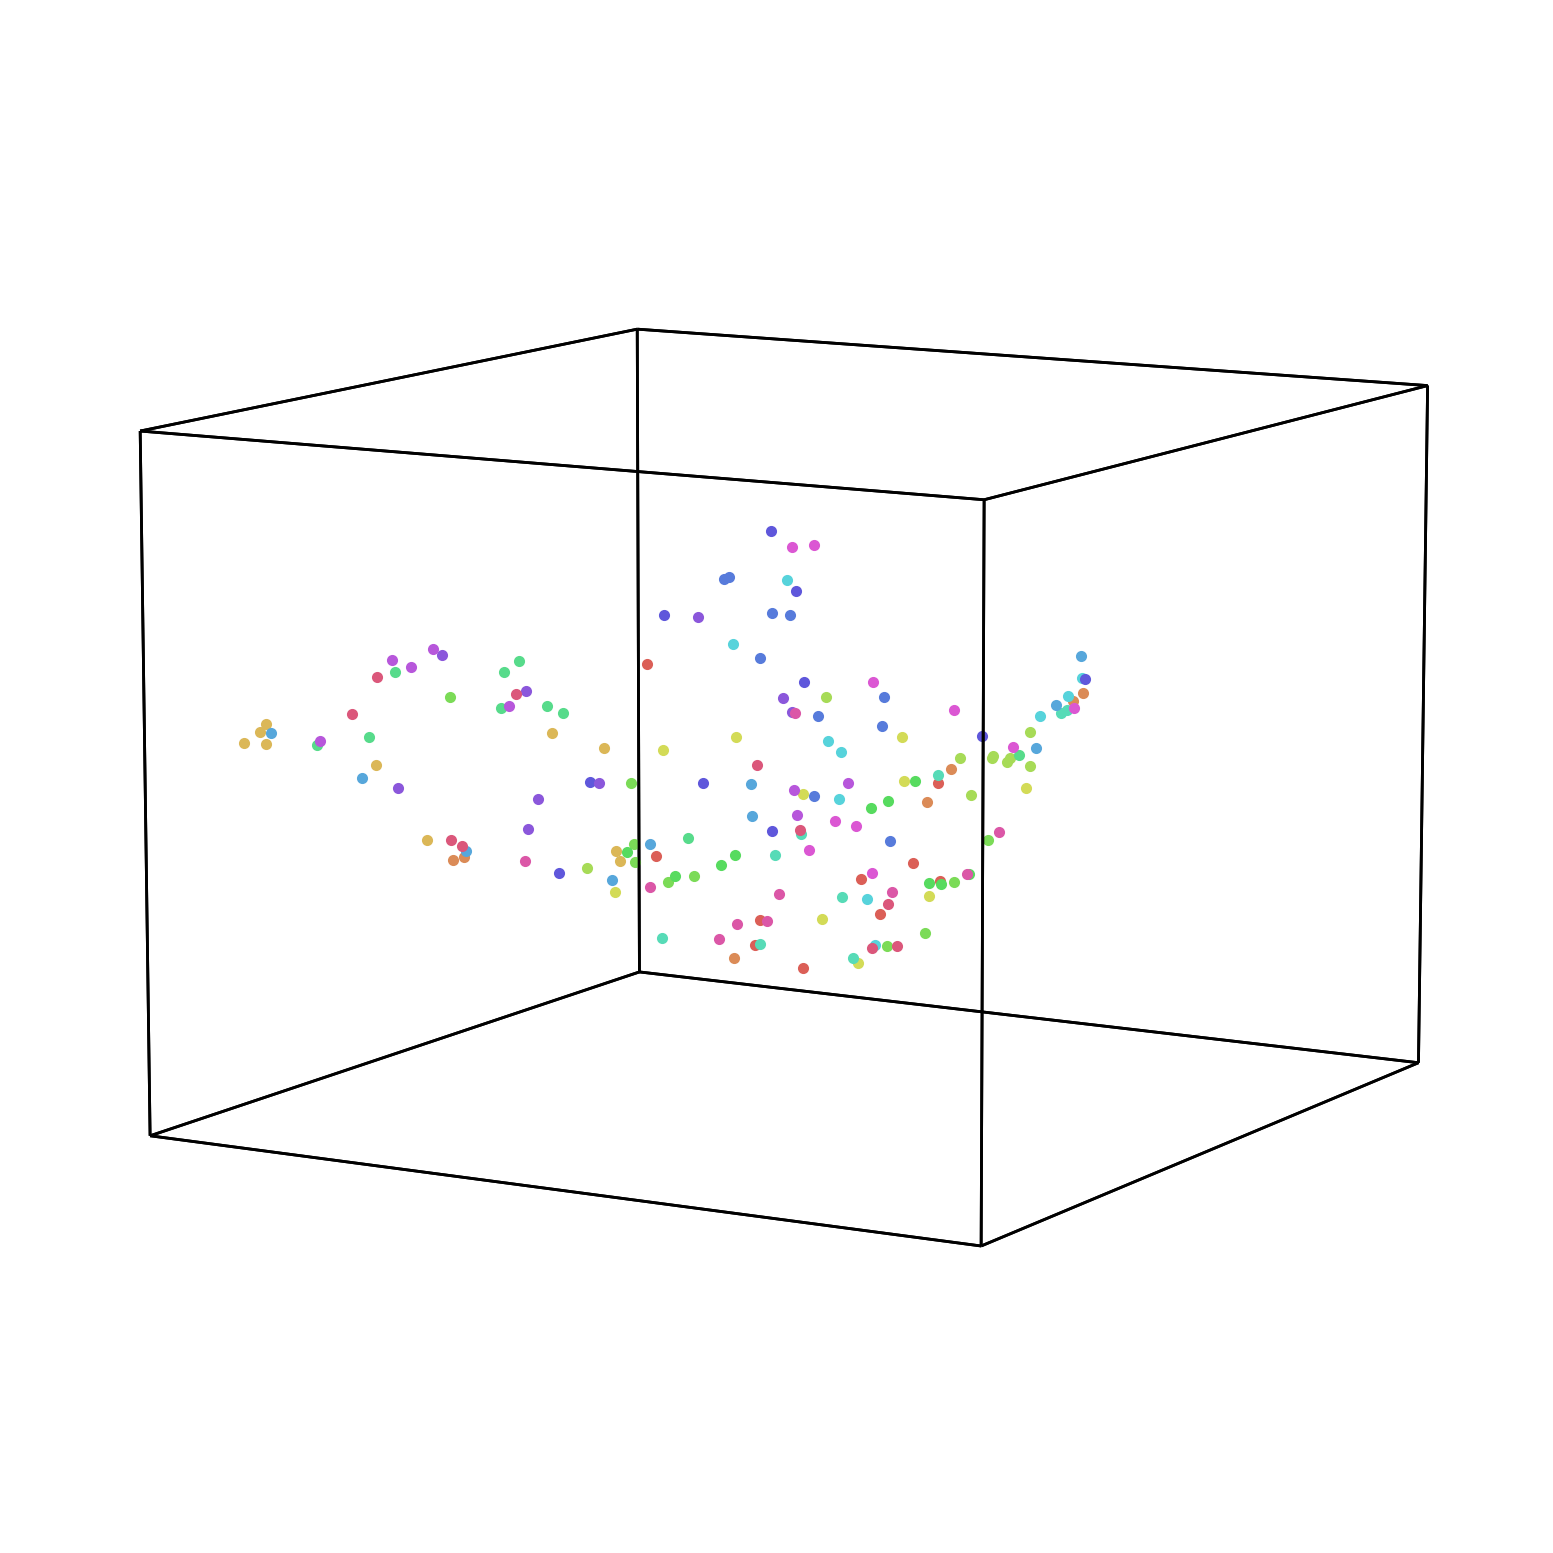

In [42]:
hyp.plot(df, '.', reduce='UMAP', hue=class_names, ndims=3)

In [43]:
prototypes = {}
for k,v in map_acr_full.items():
    prototypes[v] = np.mean(embed_arr[v == np.asarray(class_names)],axis=0)

In [44]:
prototypes

{'ascending stairs': array([-0.6044539, 12.189519 ,  2.492359 , ..., -4.5140915,  4.4088545,
         4.7601104], dtype=float32),
 'car driving': array([  9.748316 ,  20.076887 , -15.291671 , ...,   7.9355497,
          5.673073 ,   7.055671 ], dtype=float32),
 'computer work': array([ 18.622967 ,  -5.8897095, -11.938574 , ...,   3.1311648,
          4.9550366, -10.107033 ], dtype=float32),
 'cycling': array([ 0.2658163, 11.501283 ,  1.6080472, ..., -6.0614696,  3.6521385,
         2.3853762], dtype=float32),
 'descending stairs': array([-5.8904877, 24.591677 , -9.924695 , ..., -7.062352 ,  5.681396 ,
         5.968072 ], dtype=float32),
 'folding laundry': array([ 5.2019634,  0.2939968, -2.2404995, ..., -4.893197 , -1.226159 ,
        -1.8141079], dtype=float32),
 'house cleaning': array([ 2.6248927, 12.147528 , 12.033819 , ..., -7.207026 ,  2.9452846,
         4.478574 ], dtype=float32),
 'ironing': array([ 11.041849 ,   3.21625  ,  -0.6425745, ...,  -1.7187378,
          0.9105751, 

In [45]:
df = pd.DataFrame.from_dict(prototypes,orient="index")

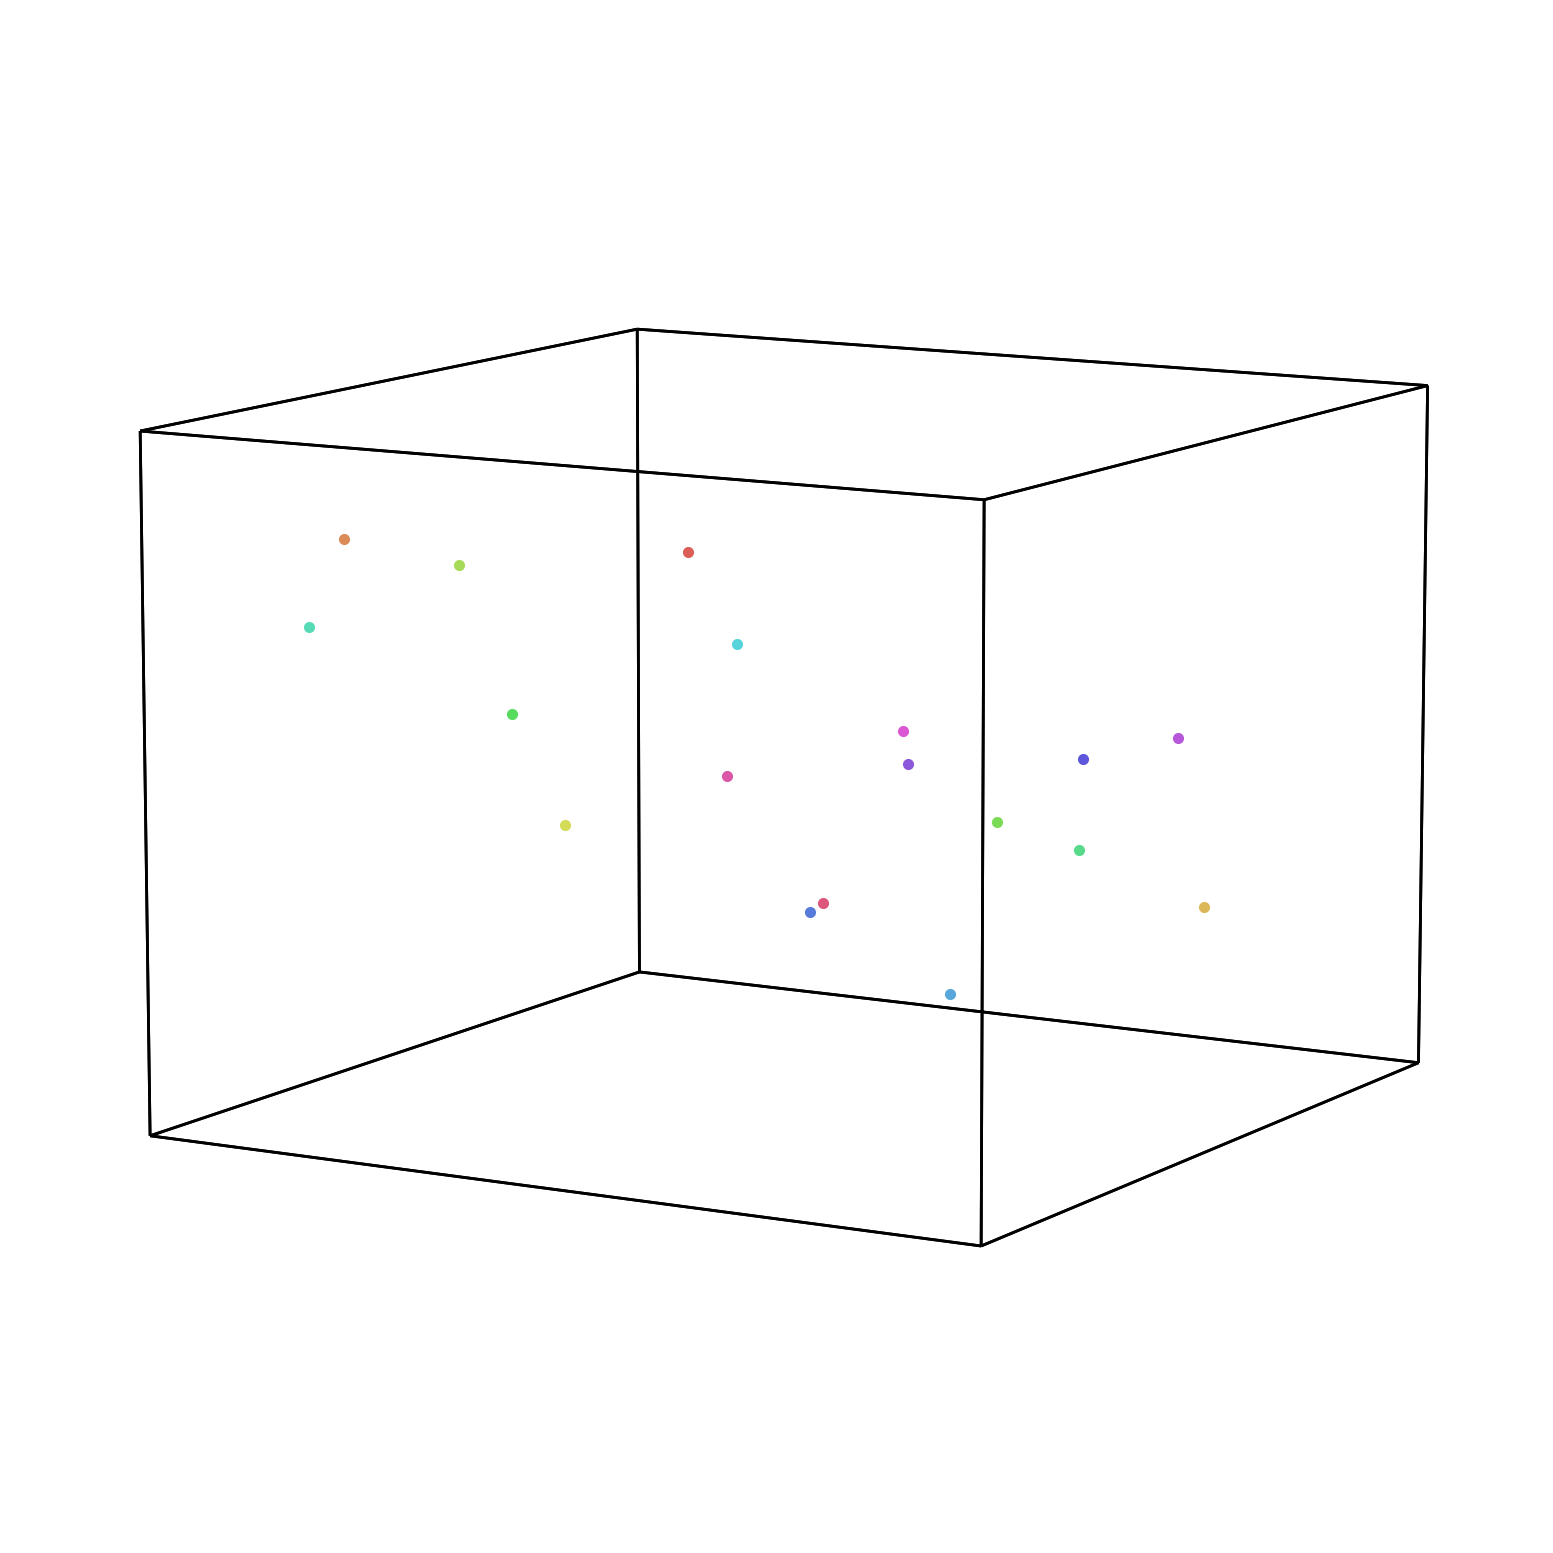

In [46]:
hyp.plot(df, '.', reduce='UMAP', hue=df.index, ndims=3)

In [47]:
os.makedirs(f"{prototypes_save}/{model_ident}/{unique_iden}",exist_ok=True)

with open(f"{prototypes_save}/{model_ident}/{unique_iden}/without_pretrain_on_local.pkl","wb") as f0:
    pickle.dump(prototypes,f0)